[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train RF-DETR Object Detection on a Custom Dataset

---

[![hf space](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/RF-DETR)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-rf-detr-on-detection-dataset.ipynb)
[![roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/rf-detr)
[![code](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/rf-detr)

RF-DETR is a real-time, transformer-based object detection model architecture developed by Roboflow and released under the Apache 2.0 license.

![rf-detr-coco-rf100-vl-8](https://media.roboflow.com/rfdetr/pareto.png)

The RF-DETR family of models stands as the quickest and most precise in object detection across all sizes. RF-DETR has achieved over 60 mAP on the Microsoft COCO benchmark, a leading measure of object detection performance. It also sets new records on RF100-VL, a benchmark that shows how well models adapt to real-world problems beyond standard datasets.

The RF-DETR model group includes five sizes: Nano, Small, Medium, Base, and Large. These models offer a range of options for different needs. For example, RF-DETR-Nano is 11 mAP higher than YOLO11-n (on mAP50:95) and runs 0.17 ms faster. Likewise, RF-DETR-Small is 1.8 mAP better than YOLO11-x (the biggest YOLO11 model) and speeds things up by a good 7.77 ms. This wide range of models makes RF-DETR a great choice for many real-world uses, from small devices that need to be super fast to bigger jobs that demand top precision.

RF-DETR is small enough to run on edge devices, making it perfect for deployments that need both high accuracy and real-time performance. You can easily get started with any of the RF-DETR models, as they're ready for training in the cloud with Roboflow or through the free RF-DETR Python package.

## Environment setup

### Configure API Key

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy` to copy your private API key.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store your Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Jul 24 07:20:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   50C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

Installs RF-DETR version 1.2.0 or higher (which includes the new Nano, Small, and Medium checkpoints), along with Supervision for benchmarking and Roboflow for pulling datasets and uploading models to the Roboflow platform.

In [ ]:
!pip install -q rfdetr==1.2.0 supervision==0.26.1 roboflow

### Download example data

Downloads example images for testing. You can use these or replace them with your own images.

In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with Pre-trained COCO Model

Runs inference on an example image using a pretrained RF-DETR Medium model (trained on COCO). To use a different model size, simply replace `RFDETRMedium` with `RFDETRNano`, `RFDETRSmall`, `RFDETRBase` or `RFDETRLarge` as needed.

rf-detr-medium.pth: 100%|██████████| 386M/386M [00:04<00:00, 101MiB/s] 


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


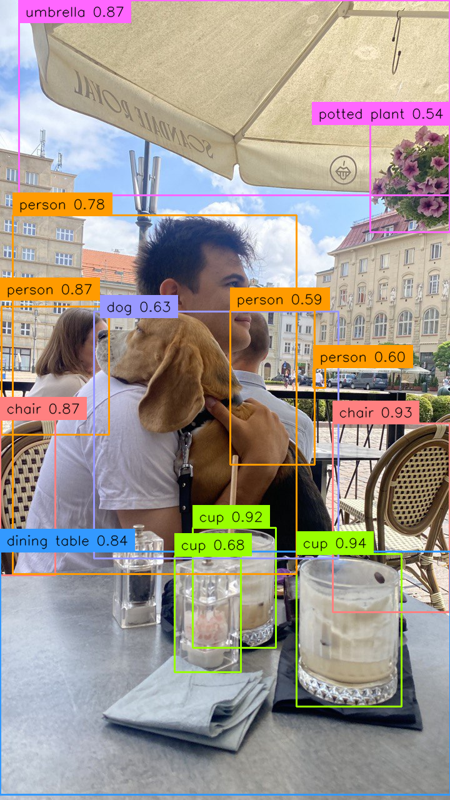

In [ ]:
import numpy as np
import supervision as sv

from PIL import Image

from rfdetr import RFDETRMedium
from rfdetr.util.coco_classes import COCO_CLASSES

image = Image.open("dog-2.jpeg")

model = RFDETRMedium(resolution=640)
detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image.thumbnail((800, 800))
annotated_image

## Download dataset from Roboflow Universe

In [ ]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/roboflow-jvuqo/basketball-player-detection-2/13", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to basketball-player-detection-2-13 in coco:: 100%|██████████| 1406/1406 [00:00<00:00, 3872.31it/s]


## Train RF-DETR on custom dataset

### Choose the right `batch_size`

Different GPUs have different amounts of VRAM (video memory), which limits how much data they can handle at once during training. To make training work well on any machine, you can adjust two settings: `batch_size` and `grad_accum_steps`. These control how many samples are processed at a time. The key is to keep their product equal to 16 — that’s our recommended total batch size. For example, on powerful GPUs like the A100, set `batch_size=16` and `grad_accum_steps=1`. On smaller GPUs like the T4, use `batch_size=4` and `grad_accum_steps=4`. We use a method called gradient accumulation, which lets the model simulate training with a larger batch size by gradually collecting updates before adjusting the weights.

In [ ]:
from rfdetr import RFDETRMedium

model = RFDETRMedium()

model.train(dataset_dir=dataset.location, epochs=5, batch_size=8, grad_accum_steps=2, lr=1e-4)

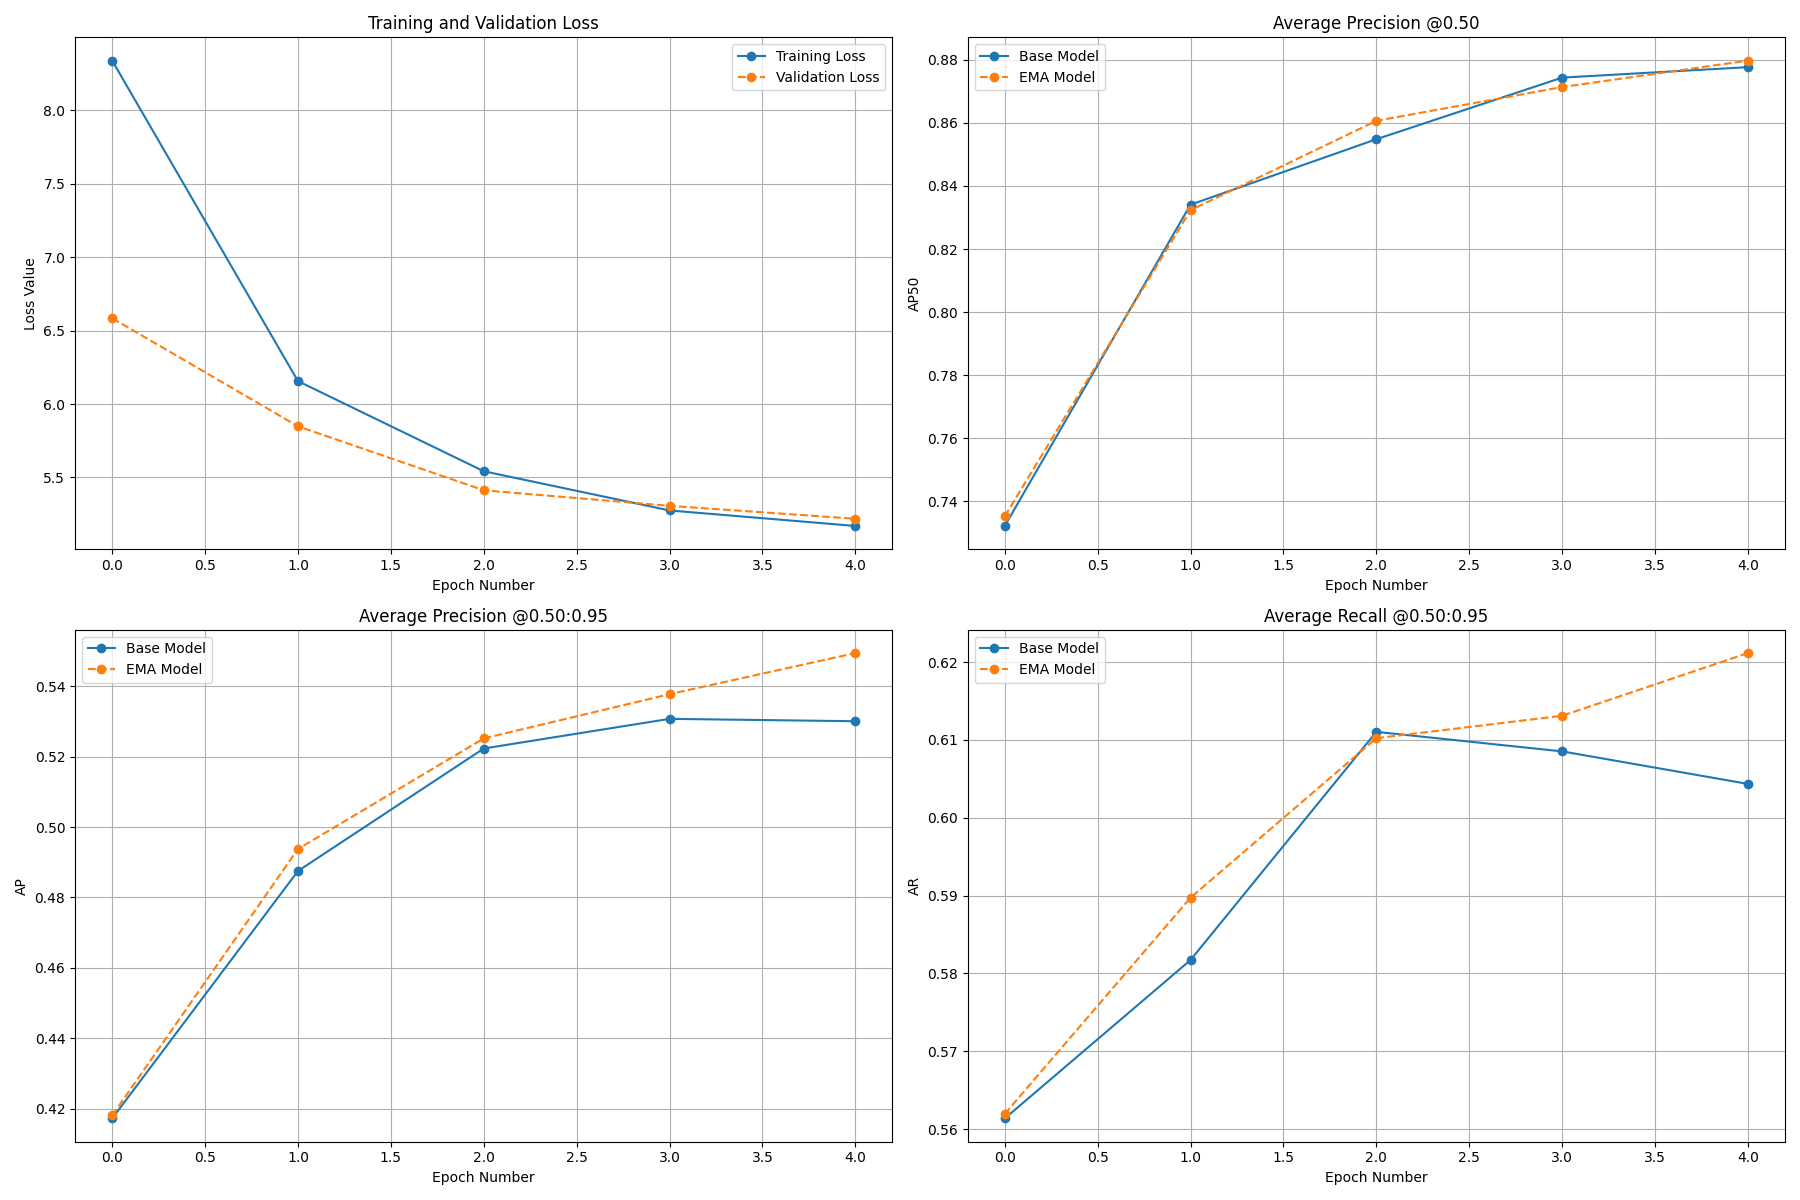

In [ ]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

## Run Inference with Fine-tuned RF-DETR Model

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

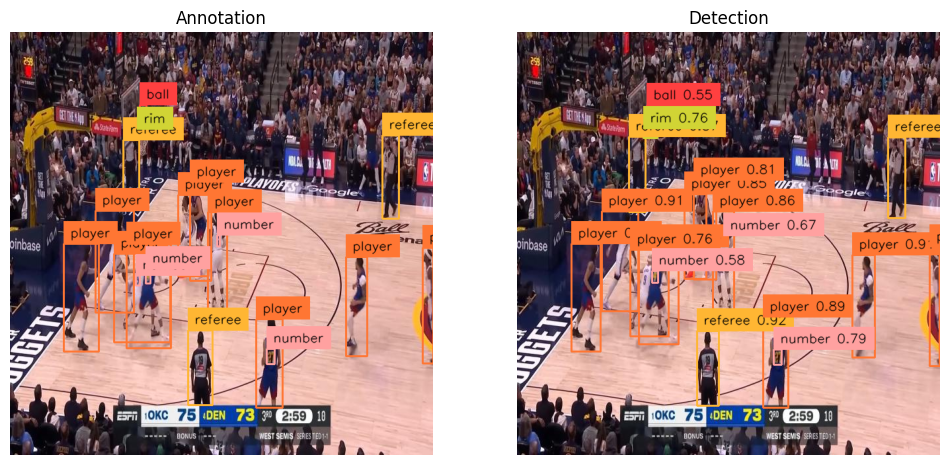

In [ ]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

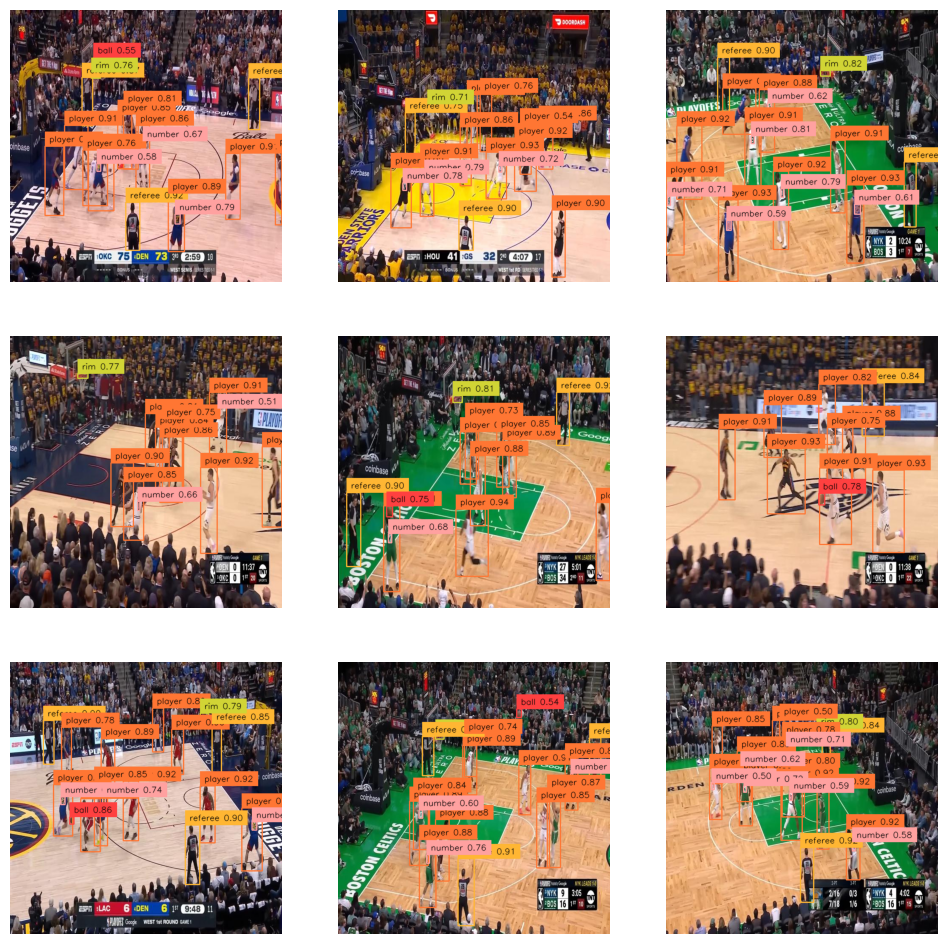

In [ ]:
import supervision as sv
from PIL import Image

detections_images = []

for i in range(9):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(3, 3), size=(12, 12))

## Evaluate Fine-tuned RF-DETR Model

In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 169/169 [00:05<00:00, 29.72it/s]


In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.523
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.833
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.542
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.235
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.718
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.851


<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>